# Spatial Land/Sea Mask

Authors: [Jason Boutte](https://github.com/jasonb5/) & [Jiwoo Lee](https://github.com/lee1043/) & [Tom Vo](https://github.com/tomvothecoder/)

Updated: 10/09/25 [xcdat v0.9.1]

Related APIs:

- [xarray.Dataset.spatial.mask_land()](../generated/xarray.Dataset.spatial.mask_land.rst)
- [xarray.Dataset.spatial.mask_sea()](../generated/xarray.Dataset.spatial.mask_sea.rst)
- [xarray.Dataset.spatial.generate_land_sea_mask()](../generated/xarray.Dataset.spatial.generate_land_sea_mask.rst)


## Overview

In geophysical sciences it can often be useful to mask data that is not of interest. Spatial land/sea masking functionality in xcdat allows users to quickly generate and apply land/sea masks derived from various methods.

In the example below, we demonstrate masking land/sea, generating land/sea masks and customizing the mask generation.

The data used in this example can be found in the [xcdat-data repository](https://github.com/xCDAT/xcdat-data).


### Notebook Kernel Setup

Users can [install their own instance of xcdat](../getting-started-guide/installation.rst) and follow these examples using their own environment (e.g., with VS Code, Jupyter, Spyder, iPython) or [enable xcdat with existing JupyterHub instances](../getting-started-guide/getting-started-hpc-jupyter.rst).

First, create the conda environment:

```bash
conda create -n xcdat_notebook -c conda-forge xcdat xesmf matplotlib ipython ipykernel cartopy nc-time-axis gsw-xarray jupyter pooch
```

Then install the kernel from the `xcdat_notebook` environment using `ipykernel` and name the kernel with the display name (e.g., `xcdat_notebook`):

```bash
python -m ipykernel install --user --name xcdat_notebook --display-name xcdat_notebook
```

Then to select the kernel `xcdat_notebook` in Jupyter to use this kernel.


## 1. Open the `Dataset`


In [1]:
# parameters
import xcdat as xc
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# open dataset
ds = xc.tutorial.open_dataset("tas_amon_access", use_cftime=True)
ds

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 60, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) object 480B 1870-01-16 12:00:00 ... 1874-12-16 12:00:00
  * lat        (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon        (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 960B ...
    lat_bnds   (lat, bnds) float64 2kB ...
    lon_bnds   (lon, bnds) float64 3kB ...
    tas        (time, lat, lon) float32 7MB ...
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    variant_label:                   r10i1p1f1
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

## 2. Masking land/sea


xCDAT supports two methods of generating land/sea mask.

- `regionmask` - This method uses the [regionmask](https://regionmask.readthedocs.io/en/stable/) package to generate the mask.
- `pcmdi` - This method uses the PCMDI method developed by [Taylor and Doutriaux (2000)](https://pcmdi.llnl.gov/report/ab58.html) to generate the mask.

The `regionmask` method uses the [1:100M Natrual Earth Land data](https://www.naturalearthdata.com/downloads/110m-physical-vectors/110m-land/) as the mask source.

The `pcmdi` method uses the `navy_land.nc` dataset; a high resolution land/sea mask with fractional land values in an iterative refinement process to generate a highly accurate mask.


In [2]:
mask = ds.spatial.mask_land("tas")

pcmdi_mask = ds.spatial.mask_land("tas", method="pcmdi")

Text(0.5, 1.0, 'PCMDI')

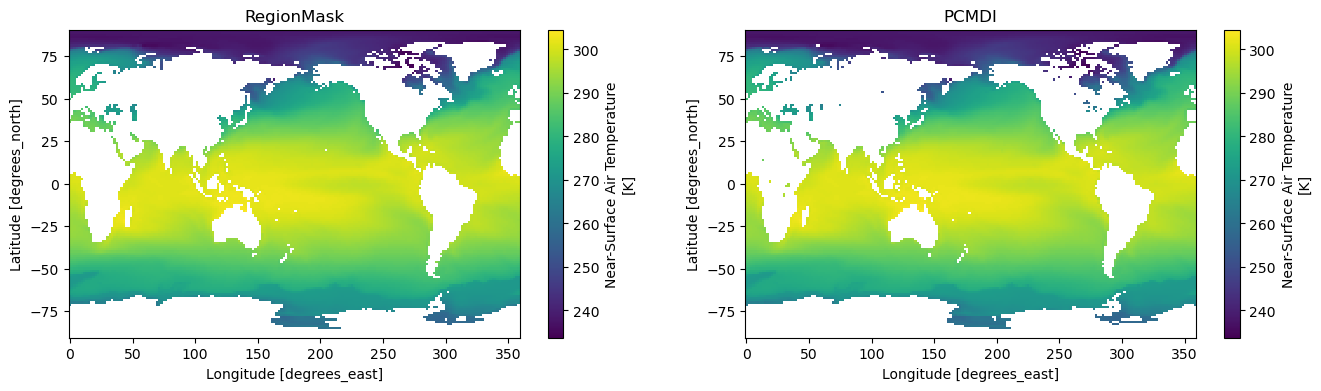

In [3]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
mask.isel(time=0).tas.plot(ax=axs[0])
axs[0].set_title("RegionMask")
pcmdi_mask.isel(time=0).tas.plot(ax=axs[1])
axs[1].set_title("PCMDI")

In [4]:
mask = ds.spatial.mask_sea("tas")

pcmdi_mask = ds.spatial.mask_sea("tas", method="pcmdi")

Text(0.5, 1.0, 'PCMDI')

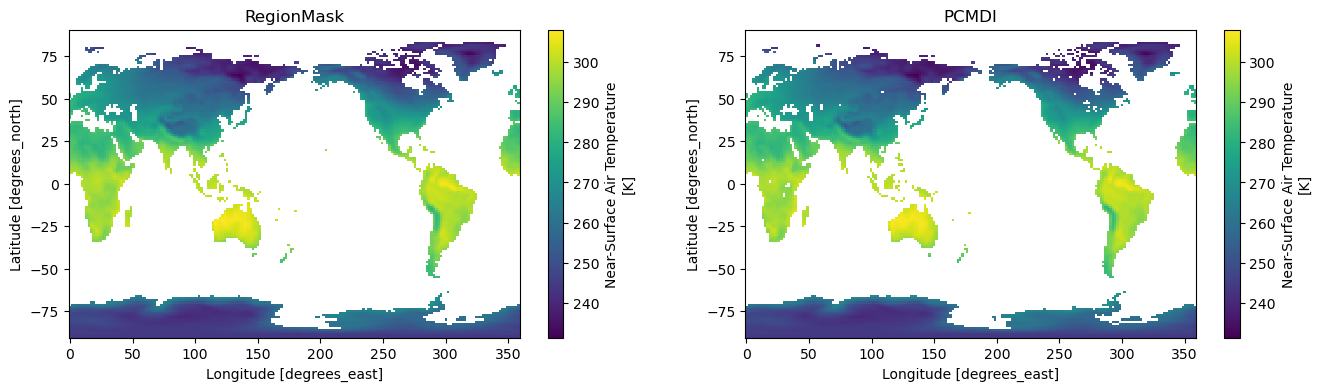

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
mask.isel(time=0).tas.plot(ax=axs[0])
axs[0].set_title("RegionMask")
pcmdi_mask.isel(time=0).tas.plot(ax=axs[1])
axs[1].set_title("PCMDI")

## 3. Generating a land/sea mask


In [6]:
grid = xc.create_uniform_grid(-90, 90, 1, 0, 359, 1)

mask = grid.spatial.generate_land_sea_mask()

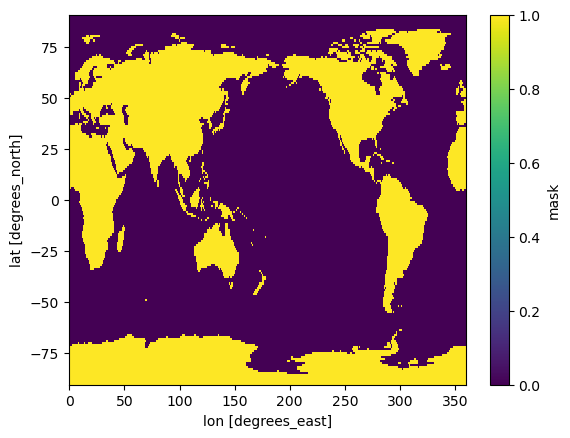

In [7]:
mask.plot()

## 4. Customizing land/sea mask


The first example customization is using a different fractional high resolution source. By default the `navy_land.nc` from [xcdat-data repo](https://github.com/xCDAT/xcdat-data) is used but it's possible to use a difference source.

**This is just a toy example using high resolution noise.**


Text(0.5, 1.0, 'Custom Source')

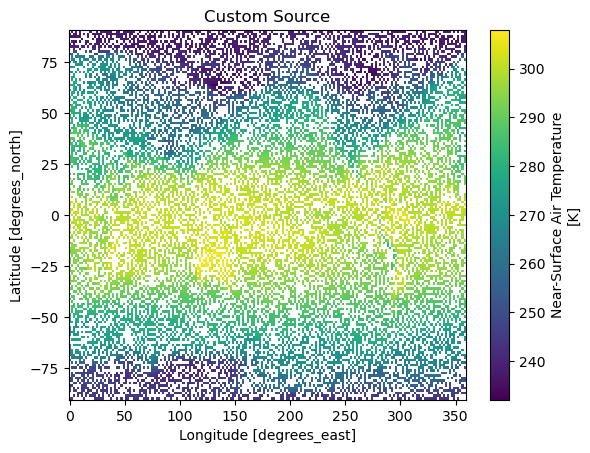

In [8]:
highres_ds = xc.create_uniform_grid(-90, 90, 1/6, 0, 359, 1/6)
highres_ds["frac"] = (("lat", "lon"), np.random.random((highres_ds.lat.shape[0], highres_ds.lon.shape[0])))

mask = ds.spatial.mask_land("tas", method="pcmdi", source=highres_ds, source_data_var="frac")
mask.tas.isel(time=0).plot()
plt.title("Custom Source")

The next example changes the thresholds used to determine if a cell should be flipped from land to sea during the iterative mask refinement performed by the `pcmdi` method.

**The default thresholds are 0.2 and 0.3.**


In [9]:
mask1 = ds.spatial.mask_land("tas", method="pcmdi", threshold1=0.6, threshold2=0.8)

mask2 = ds.spatial.mask_land("tas", method="pcmdi", threshold1=0.1, threshold2=0.2)

Text(0.5, 1.0, 'Lower')

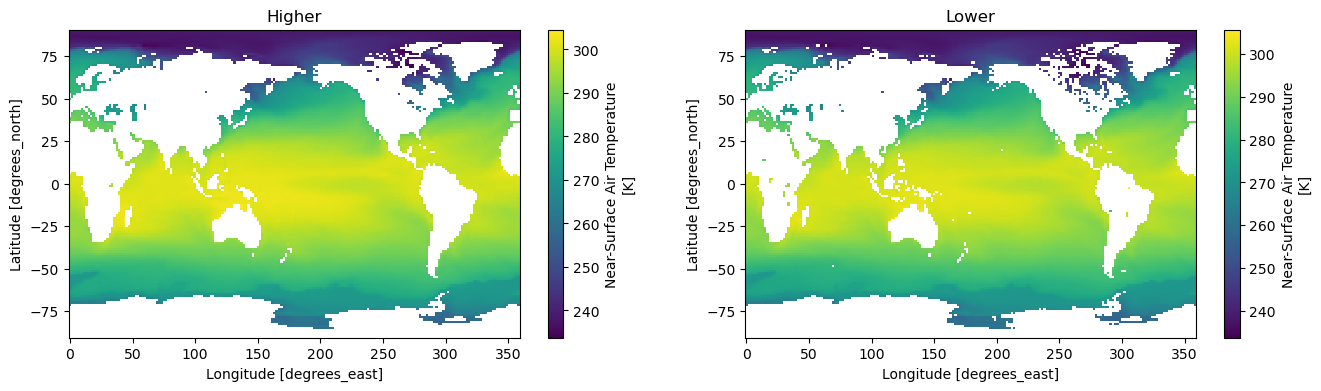

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
mask1.isel(time=0).tas.plot(ax=axs[0])
axs[0].set_title("Higher")
mask2.isel(time=0).tas.plot(ax=axs[1])
axs[1].set_title("Lower")